In [1]:
!wget "https://wallpaperaccess.com/full/36877.jpg"

--2019-12-25 07:09:06--  https://wallpaperaccess.com/full/36877.jpg
Resolving wallpaperaccess.com (wallpaperaccess.com)... 51.79.81.73
Connecting to wallpaperaccess.com (wallpaperaccess.com)|51.79.81.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130835 (128K) [image/jpeg]
Saving to: ‘36877.jpg’

36877.jpg           100%[===================>] 127.77K   697KB/s    in 0.2s    

2019-12-25 07:09:07 (697 KB/s) - ‘36877.jpg’ saved [130835/130835]



In [0]:
from PIL import Image
import matplotlib.pyplot as plt

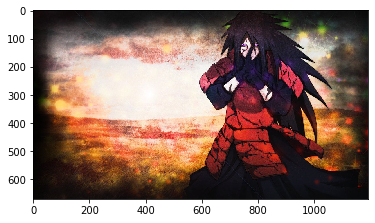

In [3]:
image = Image.open("36877.jpg")
plt.imshow(image)


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from PIL import Image
import os
import tqdm
import scipy.ndimage as nd

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np


def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [6]:
def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()


def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main deep dream method """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
        # Add deep dream detail from previous octave to new base
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image)


# Load image
image = image

# Define the model
network = models.vgg19(pretrained=True)
layers = list(network.features.children())
model = nn.Sequential(*layers[: (26 + 1)])
if torch.cuda.is_available:
    model = model.cuda()
print(network)

# Extract deep dream image
dreamed_image = deep_dream(
    image,
    model,
    iterations=20,
    lr=0.01,
    octave_scale=1.4,
    num_octaves=10,
)

# Save and plot image

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Dreaming: 100%|██████████| 10/10 [00:08<00:00,  1.88s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


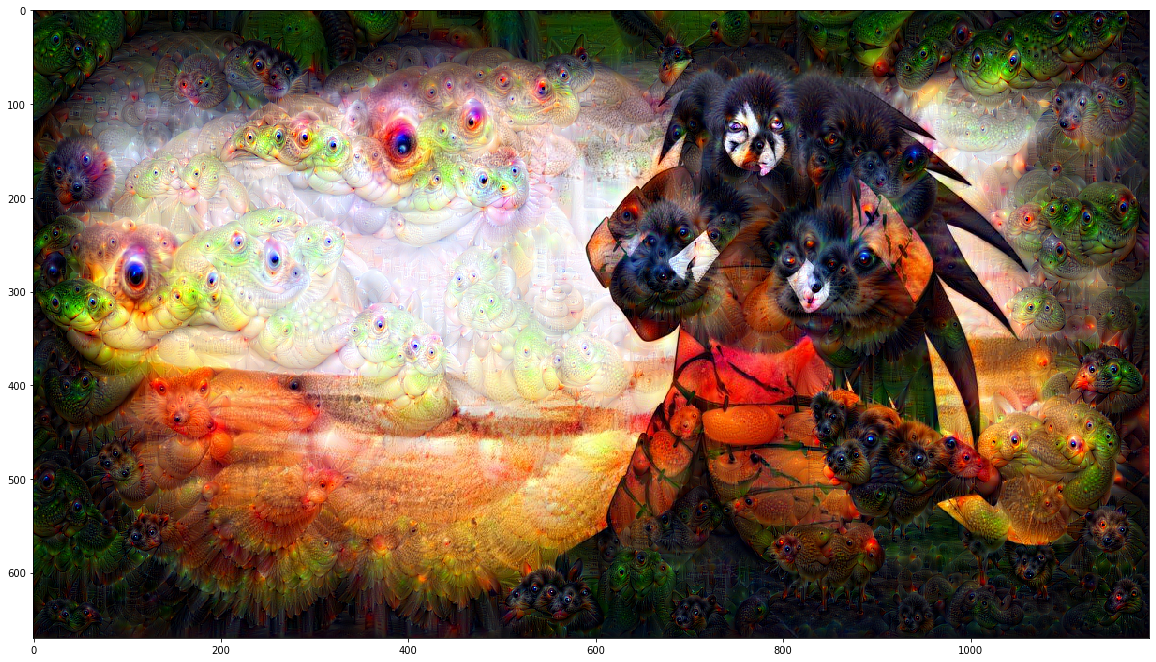

In [7]:
fig,ax = plt.subplots(figsize=(20,20))
ax.imshow(dreamed_image)
plt.show()